# Navigation

A project from Deep Reinforcement Learning Engineer Nandodegree at Udacity.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment

Next, start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`
```

In [2]:
env = UnityEnvironment(file_name="./Banana_Linux/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [4]:
class DizzyAgent:
    __MAX_TIMESTEPS = 2000

    def __init__(self, env, num_episodes):
        """
        Initialize the dizzy agent.

        Args:
            env (UnityEnvironment): Environment to interact with.
            num_episodes (int): Number of episodes to run.
        """
        self.num_episodes = num_episodes
        self.env = env
        self.action_size = brain.vector_action_space_size

    def start(self):
        """
        Start training the dizzy agent.

        Note:
            This agent is called dizzy as it takes random actions to interact with the environment.
            It does not learn from the environment as it does not use the states and rewards from it.
            It just saves the reward and hopes it has a good one.

            This is just for illustrative purposes.
        """
        scores = []
        for i in range(0, self.num_episodes):
            _ = self.env.reset(train_mode=True)[brain_name]
            score = 0

            for t in range(DizzyAgent.__MAX_TIMESTEPS):
                action = np.random.randint(self.action_size)
                env_info = env.step(action)[brain_name]
                reward = env_info.rewards[0]
                done = env_info.local_done[0]
                score += reward
                scores.append(score)
                if done:
                    break

            print(f'\rEpisode {i}\tScore: {score}', end='')

        print(f'\rAverage score {np.mean(scores):.2f}', end='')

        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(scores)), scores)
        plt.plot(np.arange(len(scores)), [np.mean(scores)] * len(scores))
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        ax.legend(['Score', 'Average Score'])
        plt.show()

Average score 0.110.00

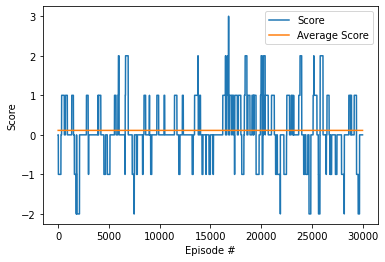

In [5]:
num_episodes = 100
dizzy_agent = DizzyAgent(env, num_episodes)
dizzy_agent.start()

In [42]:
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [58]:
import torch.nn as nn

class DNN(nn.Module):
    def __init__(self, state_size, action_size, fc1_units=128, fc2_units=64):
        """
        Initialize deep neural network, consisting of 3 fully connected layers, and
        an ReLU6 activation function.
        
        Args:
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(DNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_size, fc1_units),
            nn.ReLU6(),
            nn.Linear(fc1_units, fc2_units),
            nn.ReLU6(),
            nn.Linear(fc2_units, action_size),
        )

    def forward(self, state):
        return self.model(state)

In [44]:
from collections import namedtuple

class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size):
        """
        Initialize a replay buffer.

        Note:
            The data structure used to save the experiences is a queue of size `buffer_size`.
            The queue is a queue of `namedtuples`.
        
        Args:
            action_size (int): Dimension of each action.
            buffer_size (int): Maximum size of buffer.
            batch_size (int): Size of each training batch.
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple('Experience', field_names=['state', 'action', 'reward', 'next_state', 'done'])
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    def add(self, state, action, reward, next_state, done):
        """
        Add a new experience to memory.

        Args:
            state (numpy.array):
            action (numpy.array):
            reward (float):
            next_state (numpy.array):
            done (bool): A flag to indicate if episode is done.
        """
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
  
        return states, actions, rewards, next_states, dones

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [52]:
from collections import deque
import numpy as np
import random
import torch
import torch.optim as optim

class DQN:
    __BUFFER_SIZE = 10000     # Replay buffer size
    __BATCH_SIZE = 64         # Minibatch size
    __GAMMA = 0.99            # Discount factor
    __TAU = 0.05              # For soft update of target parameters
    __LR = 5e-4               # Learning rate
    __UPDATE_EVERY = 4        # Network update rate
    __EPSILON_START = 1       # Epsilon start value
    __EPSILON_MIN = 0.001     # Epsilon min value
    __EPSILON_DECAY = 0.99    # Epsilon decay value
    __N_EPISODES = 2000       # Number of episodes
    __MAX_TIMESTEPS = 1000    # Max number of timesteps per episode
    __GOAL = 14               # Goal to consider the problem solved

    def __init__(self, state_size, action_size):
        """
        Initialize a DQN agent according to the set of states and set of actions from the environment.

        Note:
            It contains hyperparameters to tune the training stage, e.g. discount factor,
            number of epsiodes, etc.
            It uses a conventional 3-layer Deep Neural Network (DNN); each layer is a fully-connected
            layer (refer to DNN class for more details).

        Args:
            state_size (int): dimension of each state
            action_size (int): dimension of each action

        Example:
            >>> dqn = DQN(37, 4)
        """
        self.state_size = state_size
        self.action_size = action_size

        self.dnn_local = DNN(state_size, action_size).to(device)
        self.dnn_target = DNN(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.dnn_local.parameters(), lr=DQN.__LR)

        self.memory = ReplayBuffer(action_size, DQN.__BUFFER_SIZE, DQN.__BATCH_SIZE)

        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def train(self, env, brain_name):
        """
        Train the agent based on the environment and brain.

        Args:
            env (UnityEnvironment): Environment to train with.
            brain_name (str): Name of the brain.

        Example:
            >>> dqn = DQN(37, 4)
            >>> dqn.train(UnityEnvironment(file_name='/path/to/Environment.app'), 'EnvironmentBrain')
        """
        scores = []
        scores_window = deque(maxlen=100)
        eps = DQN.__EPSILON_START
        for i_episode in range(1, DQN.__N_EPISODES+1):
            env_info = env.reset(train_mode=True)[brain_name]
            state = env_info.vector_observations[0]
            score = 0
            for t in range(DQN.__MAX_TIMESTEPS):
                action = self.act(state, eps)
                env_info = env.step(action)[brain_name] 
                next_state = env_info.vector_observations[0]   
                reward = env_info.rewards[0]               
                done = env_info.local_done[0]      
                self.step(state, action, reward, next_state, done)
                state = next_state
                score += reward
                if done:
                    break 
                
            scores_window.append(score)       
            scores.append(score)              
            eps = max(DQN.__EPSILON_MIN, DQN.__EPSILON_DECAY*eps)

            print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}', end="")
            
            if i_episode % 100 == 0:
                print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}')
            
            if np.mean(scores_window)>= DQN.__GOAL:
                print(f'\nEnvironment solved in {i_episode-100:d} episodes!\tAverage Score: {np.mean(scores_window):.2f}')
                torch.save(self.dnn_local.state_dict(), 'weights.pth')
                break

        return scores, scores_window
    
    def test(self, env, brain_name, filename):
        """
        Test the agent based on the environment and brain.

        Args:
            env (UnityEnvironment): Environment to train with.
            brain_name (str): Name of the brain.
            filename (str): Name of the file to store the weights.

        Example:
            >>> dqn = DQN(37, 4)
            >>> dqn.test(UnityEnvironment(file_name='/path/to/Environment.app'), 'EnvironmentBrain', 'weights.pth')
        """

        weights = torch.load(filename)
        self.dnn_local.load_state_dict(weights)
        self.dnn_target.load_state_dict(weights)
            
        env_info = env.reset(train_mode=False)[brain_name]
        state = env_info.vector_observations[0]
               
        for t in range(DQN.__MAX_TIMESTEPS):
            action = self.act(state, 0)
            env_info = env.step(action)[brain_name] 
            next_state = env_info.vector_observations[0]         
            done = env_info.local_done[0]      
            state = next_state
 
            if done:
                break 

    def step(self, state, action, reward, next_state, done):
        """
        Perform a step in the training process.

        Note:
            Firstly, saves the state in the replay experience buffer (state, action, reward, next_state, done).
            If there are enough numbers of samples in the memory, just sample one of them randomly, and help
            the learning process with it.

        Args:
            state (numpy.array): The current state from which an action has been selected.
            action (numpy.array): The action selected based on the current state.
            reward (float): The reward obtained after applying the action.
            next_state (numpy.array): The next state to which the environment will transition after applying the action.
            done (bool): A flag that says if the episode is done.
        """

        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % DQN.__UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory) > DQN.__BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, DQN.__GAMMA)

    def act(self, state, eps=0.):
        """
        Returns actions for given state as per current policy.

        Note:
            Uses an epsilon-greedy action selection.

        Args:
            state (numpy.array): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.dnn_local.eval()
        with torch.no_grad():
            action_values = self.dnn_local(state)
        self.dnn_local.train()

        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """
        Update value parameters using given batch of experience tuples.
        
        Args:
            experiences (Tuple[torch.Variable]): Tuple of (state, action, reward, next_state, done) tuples
            gamma (float): Discount factor.
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.dnn_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.dnn_local(states).gather(1, actions)

        loss = torch.nn.MSELoss()
        output = loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        output.backward()
        self.optimizer.step()
        
        self.soft_update(DQN.__TAU)

    def soft_update(self, tau):
        """
        Soft update model weights.

        Note:
            θ_target = τ * θ_local + (1 - τ) * θ_target
        
        Args:
            tau (float): Interpolation parameter
        """
        for target_param, local_param in zip(self.dnn_target.parameters(), self.dnn_local.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

In [53]:
class Training:
    def start(env):
        """
        Start training.

        Note:
            Train mode should be enabled.

        Args:
            env (UnityEnvironment): Environment to train with.
        """
        env_info = env.reset(train_mode=True)[brain_name]

        action_size = brain.vector_action_space_size

        state_size = len(env_info.vector_observations[0])

        agent = DQN(state_size, action_size)
        scores, scores_window = agent.train(env, brain_name)

        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(scores)), scores)
        plt.plot(np.arange(len(scores)), [np.mean(scores_window)] * len(scores))
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        ax.legend(['Score', 'Average Score'])
        plt.show()

In [54]:
class Evaluation:
    def start(env):
        env_info = env.reset(train_mode=False)[brain_name]
        action_size = brain.vector_action_space_size
        state_size = len(env_info.vector_observations[0])

        agent = DQN(state_size, action_size)
        agent.test(env, brain_name, 'weights.pth')

Episode 100	Average Score: 1.89
Episode 200	Average Score: 5.46
Episode 300	Average Score: 8.81
Episode 400	Average Score: 9.55
Episode 500	Average Score: 12.71
Episode 600	Average Score: 13.33
Episode 700	Average Score: 12.96
Episode 782	Average Score: 14.01
Environment solved in 682 episodes!	Average Score: 14.01


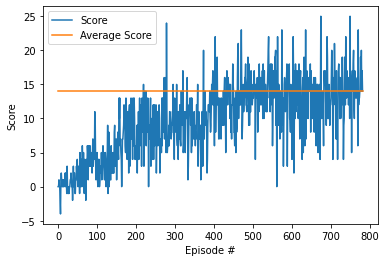

In [55]:
Training.start(env)

In [56]:
Evaluation.start(env)